# Upper-Confidence-Bound Action Selection

Uncertainty about the accuracy of the action-value estimates persists. As we have found from $\epsilon$-greedy methods, the greedy actions are those that look best at present, but some of the other actions may actually be better.

One of the drawbacks about $\epsilon$-greedy action selection is that it chooses the non-greedy actions indiscriminately, with no preference for those that are nearly greedy or particularly uncertain.

It is better to select among the non-greedy actions according to their potential for actually being optimal, taking into account both how close their estimates are to being maximal and the uncertainties in those estimates.

An effective way of doing this is to select actions according to

$$
A_t = \arg\max_a \left( Q_t(a) + c\sqrt{\frac{\log t}{N_t(a)}} \right)
$$

where $N_t(a)$ denotes the number of times that actiona $a$ has been selected prior to time step $t$, and $c>0$ controls the degree of exploration. If $N_t(a)=0$, then $a$ is considered to be a maximising action.

The square-root term is a measure of the uncertainty or variance in the estimate of $a$'s value. The quantity being maximised over is thus an upper bound on the possible true value of action $a$, with $c$ determining the confidence level.

Each time $a$ is selected the uncertainty is presumably reduced as $N_t(a)$ increases. If $a$ is not selected, then the uncertainty increases over time. It is unbounded, so all actions will eventually be selected, although actions with lower value estimates or that have already been selected frequently, will be selected with decreasing frequency.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
n_episodes = 2000
n_timesteps = 1000
k = 10
epsilon = 0.1
c = 2

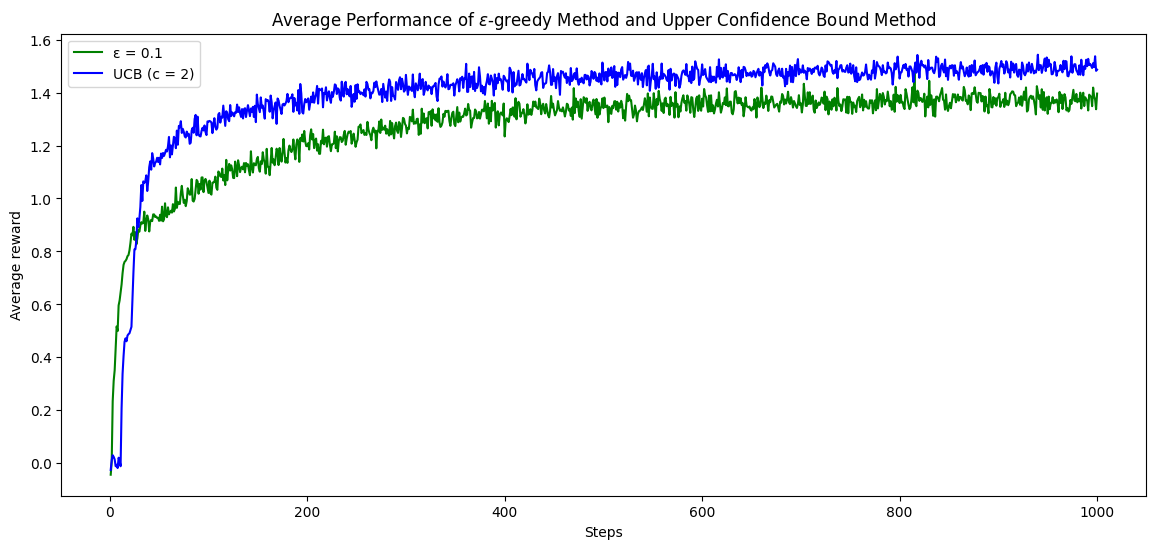

In [6]:
history = [[[0 for _ in range(n_timesteps)] for _ in range(n_episodes)] for _ in range(2)]

# for episode in range(1):
for episode in range(n_episodes):
    q_star = [np.random.normal(0, 1) for _ in range(k)]
    q_hat = [[0 for _ in range(k)] for _ in range(2)]
    action_count = [[0 for _ in range(k)] for _ in range(2)]
    
    for timestep in range(n_timesteps):       
        # epsilon-greedy
        random_number = np.random.rand()
        if random_number < epsilon:
            action_greedy = np.random.choice(range(k))
        else:
            action_greedy = np.argmax(q_hat[0])

        # select the reward
        reward_greedy = np.random.normal(q_star[action_greedy], 1)
        history[0][episode][timestep] = reward_greedy

        # update the estimate of q_star
        if not action_count[0][action_greedy]:
            pass
        else:
            q_hat[0][action_greedy] += (reward_greedy - q_hat[0][action_greedy])/action_count[0][action_greedy]

        action_count[0][action_greedy] += 1


        # ucb
        not_selected = [i for i in range(k) if not action_count[1][i]]
        
        if not_selected:
            action_ucb = np.random.choice(not_selected)
        else:
            action_ucb = np.argmax(q_hat[1] + c * np.sqrt(np.log(timestep) / action_count[1]))

        # select the reward
        reward_ucb = np.random.normal(q_star[action_ucb], 1)
        history[1][episode][timestep] = reward_ucb

        # update q_hat
        if not action_count[1][action_ucb]:
            pass
        else:
            q_hat[1][action_ucb] += (reward_ucb - q_hat[1][action_ucb])/action_count[1][action_ucb]
        
        action_count[1][action_ucb] += 1

# Calculate average reward
avg_rewards = np.zeros((2, n_timesteps))
for i in range(2):
    for t in range(n_timesteps):
        avg_rewards[i, t] = np.mean([history[i][episode][t] for episode in range(n_episodes)])

# Plotting
plt.figure(figsize=(14, 6))
colors = ['green', 'blue']
labels = [f'ε = {epsilon}', f'UCB (c = {c})']

for i in range(2):
    plt.plot(range(1, n_timesteps + 1), avg_rewards[i], color=colors[i], label=labels[i])

plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.title('Average Performance of $\epsilon$-greedy Method and Upper Confidence Bound Method')
plt.legend()
plt.show()

### Maths behind UCB

Recall that we have

$$
A_t = \arg\max_a \left( Q_t(a) + c\sqrt{\frac{\log t}{N_t(a)}} \right).
$$

Here we figure out why and how we have the expression

$$
Q_t(a) + c\sqrt{\frac{\log t}{N_t(a)}}
$$

and what it means.

A random variable $X$ is said to be from a $\sigma$-sub-Gaussian distribution with mean $\mu$ if for all $\lambda\in\mathbb R$

$$
\mathbb E\left[ e^{\lambda (X-\mu)} \right] \leq \exp\left( \frac{\lambda^2\sigma^2}{2} \right).
$$

That is, the moment generaitng function of $X$, defined as $\mathbb E\left[ e^{\lambda(X-\mu)} \right]$ is bounded by the moment generating function of a zero-mean Gaussian random variable. Intuitively, this means that the tails of the distribution will fit under a Gaussian distribution with variance $\sigma^2$.

In fact, _Hoeffding's lemma_ guarantees that any distribution that takes values in the range $[a, b]$ for $a\leq b$ is $(b-a)/2$ sub-Gaussian. Furthermore, _Hoeffding's inequality_ suggests that for i.i.d samples $X_1,\cdots, X_n$ from a $\sigma$-sub-Gaussian distribution with expected value $\mu$ and $\hat \mu=\frac{1}{n}\sum_{i=1}^n X_i$, for any $\alpha>0$ we have

$$
P(|\hat\mu -\mu|\geq \alpha)\leq 2\exp\left( -\frac{n\alpha^2}{2\sigma^2} \right)
$$

and as a corollary of the above result, we see that for any $\delta>0$, in any time step $t$, with probability greater than $1-\delta$, 

$$
|\hat\mu_{j,t}-\mu_j|\leq \sqrt{\frac{2\sigma^2\log(2/\delta)}{N_j(t)}}
$$

where $N_j(t)$ is the number of times that arm $j$ has been played up to the end of time step $t$.